# Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
import random
import math

import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_environments import make, evaluate

# Создаем ботов

In [2]:
%%writefile rock.py
def rock(observation, configuration):
    '''Агент, где выбирается камень'''
    return 0

Writing rock.py


In [3]:
%%writefile paper.py
def paper(observation, configuration):
    '''Агент, где выбирается бумага'''
    return 1

Writing paper.py


In [4]:
%%writefile scissors.py
def scissors(observation, configuration):
    '''Агент, где выбирается ножницы'''
    return 2

Writing scissors.py


In [5]:
%%writefile copy_opponent.py

import random

def copy_opponent(observation, configuration):
    '''Агент, где копируется предыдущий ход оппонента'''
    if observation.step > 0:
        return observation.lastOpponentAction
    else:
        return random.randrange(0, configuration.signs)

Writing copy_opponent.py


In [6]:
%%writefile random_agent.py

import random

def random_agent(observation, configuration):
    '''Агент, который выбирает случайный ход.'''
    return random.randrange(0, configuration.signs)

Writing random_agent.py


In [7]:
%%writefile random_chose_rock_paper.py

import random

def random_chose_rock_paper(observation, configuration):
    '''Агент, который выбирает случайный ход из двух: камня и бумаги'''
    return random.randint(0,1)

Writing random_chose_rock_paper.py


In [8]:
%%writefile random_chose_paper_scissors.py

import random

def random_chose_paper_scissors(observation, configuration):
    '''Агент, который выбирает случайный ход из двух: камня и бумаги'''
    return random.randint(1,2)

Writing random_chose_paper_scissors.py


In [9]:
%%writefile cycle_agent.py
def cycle_agent(observation, configuration):
    '''Агент, который циклично выбирает камень, бумага, ножницы.'''
    return observation.step % 3

Writing cycle_agent.py


In [10]:
%%writefile predictive_agent.py

import random

def predictive_agent(observation, configuration):
    '''Агент, который предсказывает следующий ход оппонента на основе его прошлого хода.'''
    if observation.step == 0:
        return random.randrange(0, configuration.signs)  # случайный первый ход
    else:
        # Если оппонент выбрал камень (0), ожидаем ножницы (2), и наоборот
        if observation.lastOpponentAction == 0:
            return 1  # выбираем бумагу
        elif observation.lastOpponentAction == 1:
            return 2  # выбираем ножницы
        else:
            return 0  # выбираем камень

Writing predictive_agent.py


In [11]:
%%writefile reactionary.py

import random
import math

def get_score(left_move, right_move):
    # This method exists in this file so it can be consumed from rps.py and agents.py without a circular dependency
    delta = (
        right_move - left_move
        if (left_move + right_move) % 2 == 0
        else left_move - right_move
    )
    return 0 if delta == 0 else math.copysign(1, delta)

last_react_action = None

def reactionary(observation, configuration):
    global last_react_action
    if observation.step == 0:
        last_react_action = random.randrange(0, configuration.signs)
    elif get_score(last_react_action, observation.lastOpponentAction) <= 1:
        last_react_action = (observation.lastOpponentAction + 1) % configuration.signs

    return last_react_action

Writing reactionary.py


In [12]:
%%writefile counter_reactionary.py

import math
import random

def get_score(left_move, right_move):
    # This method exists in this file so it can be consumed from rps.py and agents.py without a circular dependency
    delta = (
        right_move - left_move
        if (left_move + right_move) % 2 == 0
        else left_move - right_move
    )
    return 0 if delta == 0 else math.copysign(1, delta)

last_counter_action = None

def counter_reactionary(observation, configuration):
    global last_counter_action
    if observation.step == 0:
        last_counter_action = random.randrange(0, configuration.signs)
    elif get_score(last_counter_action, observation.lastOpponentAction) == 1:
        last_counter_action = (last_counter_action + 2) % configuration.signs
    else:
        last_counter_action = (observation.lastOpponentAction + 1) % configuration.signs

    return last_counter_action


Writing counter_reactionary.py


In [13]:
%%writefile statistical.py

action_histogram = {}


def statistical(observation, configuration):
    global action_histogram
    if observation.step == 0:
        action_histogram = {}
        return
    action = observation.lastOpponentAction
    if action not in action_histogram:
        action_histogram[action] = 0
    action_histogram[action] += 1
    mode_action = None
    mode_action_count = None
    for k, v in action_histogram.items():
        if mode_action_count is None or v > mode_action_count:
            mode_action = k
            mode_action_count = v
            continue

    return (mode_action + 1) % configuration.signs


Writing statistical.py


In [14]:

agents = {
    'rock': 'rock.py',
    'paper': 'paper.py',
    'scissors': 'scissors.py',
    'copy_opponent': 'copy_opponent.py',
    'random_agent': 'random_agent.py',
    'cycle_agent': 'cycle_agent.py',
    'predictive_agent': 'predictive_agent.py',
    'random_chose_rock_paper': 'random_chose_rock_paper.py',
    'random_chose_paper_scissors': 'random_chose_paper_scissors.py',
    'reactionary': 'reactionary.py',
    'counter_reactionary': 'counter_reactionary.py',
    'statistical': 'statistical.py'
}

In [15]:
# 2. Создаем среду для игры "камень-ножницы-бумага"
env = make("rps")

# 4. Оценка каждого бота против остальных с использованием `evaluate`
def evaluate_bots(bots, num_turnments=1):
    results = {}
    for key in bots.keys():
        results[key] = {'wins': 0, 'losses': 0, 'draws': 0}

    for i in range(num_turnments):
        print(f'Турнир {i+1}')
        for key1, bot1 in bots.items():
            for key2, bot2 in bots.items():
                print(f"Сравниваю {key1} против {key2}...")
                
                # Используем метод evaluate для оценки
                # Нужно преобразовать ботов в соответствующий формат
                result = evaluate(
                    "rps", #environment to use - no need to change
                    [bot1, bot2], #agents to evaluate
                    configuration={"episodeSteps": 100} #number of episodes 
                    )
                # Определяем победителя
                if result[0][0] > result[0][1]:
                    results[key1]['wins'] += 1
                    results[key2]['losses'] += 1
                elif result[0][0] < result[0][1]:
                    results[key1]['losses'] += 1
                    results[key2]['wins'] += 1
                else:
                    results[key1]['draws'] += 1
                    results[key2]['draws'] += 1
    return results

# Оценка и вывод результатов
last_react_action = None
last_counter_action = None
action_histogram = {}
results = evaluate_bots(agents, num_turnments=10)

Турнир 1
Сравниваю rock против rock...


Сравниваю rock против paper...
Сравниваю rock против scissors...
Сравниваю rock против copy_opponent...
Сравниваю rock против random_agent...
Сравниваю rock против cycle_agent...
Сравниваю rock против predictive_agent...
Сравниваю rock против random_chose_rock_paper...
Сравниваю rock против random_chose_paper_scissors...
Сравниваю rock против reactionary...
Сравниваю rock против counter_reactionary...
Сравниваю rock против statistical...
Сравниваю paper против rock...
Сравниваю paper против paper...
Сравниваю paper против scissors...
Сравниваю paper против copy_opponent...
Сравниваю paper против random_agent...
Сравниваю paper против cycle_agent...
Сравниваю paper против predictive_agent...
Сравниваю paper против random_chose_rock_paper...
Сравниваю paper против random_chose_paper_scissors...
Сравниваю paper против reactionary...
Сравниваю paper против counter_reactionary...
Сравниваю paper против statistical...
Сравниваю scissors против rock...
Сравниваю scissors против paper...
Сравн

In [16]:
df = pd.DataFrame(results).T
df_reset = df.reset_index().rename(columns={'index': 'Bot'})
df_reset

,Bot,wins,losses,draws
0,rock,21,121,98
1,paper,41,120,79
2,scissors,40,102,98
3,copy_opponent,31,70,139
4,random_agent,1,2,237
5,cycle_agent,20,1,219
6,predictive_agent,130,18,92
7,random_chose_rock_paper,22,83,135
8,random_chose_paper_scissors,35,61,144
9,reactionary,125,20,95


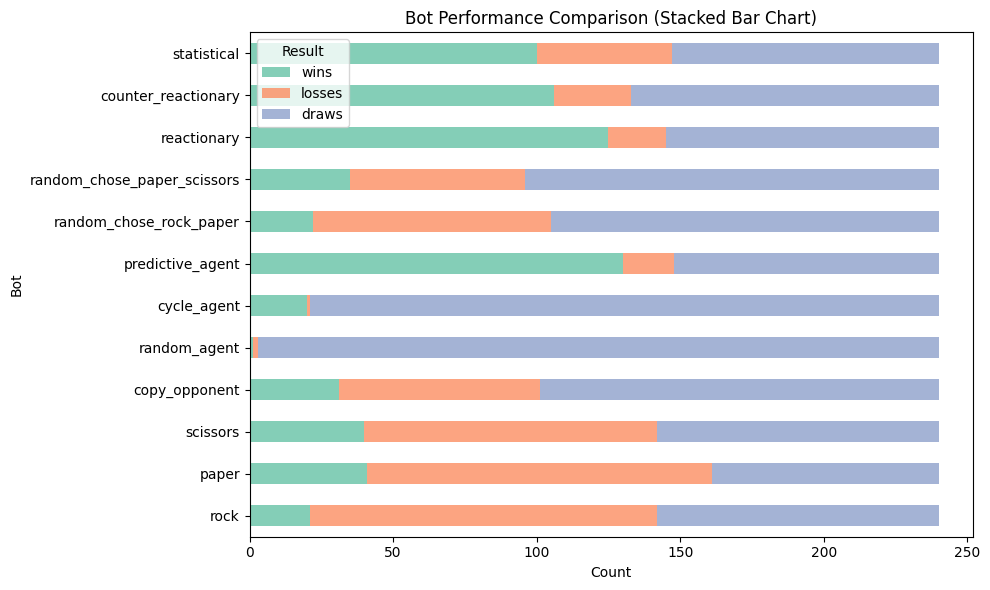

In [17]:

df_vis = df_reset.set_index('Bot')

# Построение горизонтальной столбчатой диаграммы с параметрами stacked и alpha
df_vis.plot.barh(stacked=True, alpha=0.8, figsize=(10, 6), color=['#66c2a5', '#fc8d62', '#8da0cb'])

# Настройки графика
plt.title('Bot Performance Comparison (Stacked Bar Chart)')
plt.xlabel('Count')
plt.ylabel('Bot')
plt.legend(title='Result', loc='upper left')

# Отображение графика
plt.tight_layout()
plt.show()

Для большей достоверности значений было проведено 10 турниров. Сводная таблица приведена выше.

Таким образом, в данном наборе ботов, наиболее эффективным оказался бот под названием predictive_agent, котороый предсказывает следующий ход оппонента на основе его прошлого хода. 